# WristConduct Model Training

## Imports

In [40]:
from util.crossvalidation import cross_test_subject, extract_all_mfcc_features

import numpy as np
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, roc_auc_score, matthews_corrcoef, RocCurveDisplay

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten


%matplotlib inline
import matplotlib.pyplot as plt

import math

## Definition of Constants 

In [41]:
NN_THRESHOLD = 0.85

## Load Data

In [42]:
data = extract_all_mfcc_features()

## Deep Neural Network Configuration

In [43]:
def build_model():
    model = Sequential([
    Dense(3600, activation="relu", name="layer1"),
    Dense(1024, activation="relu", name="layer2"),
    Dense(512, activation="relu", name="layer3"),
    Dense(64, activation="relu", name="layer4"),
    Dense(32, activation="relu", name="layer5"),
    Dense(1, activation='sigmoid'),
    ])

    model.compile(
    'adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'binary_accuracy'],
    )

    return model

### Define Test Result Class

In [44]:
class TestResult:
    score_nn: float
    mtx_nn: np.array
    sensitivity_nn: float
    specificity_nn: float
    score_clf: float
    mtx_clf: np.array
    sensitivity_clf: float
    specificity_clf: float

### Define Result printing Function

In [45]:
def print_scores(mtx, name):
    tn, fp, fn, tp = mtx.ravel()

    print(f"({name}) True Negatives:  {tn}")
    print(f"({name}) True Positives:  {tp}")
    print(f"({name}) False Negatives: {fn}")
    print(f"({name}) False Positives: {fp}")

    fpr = fp/(fp+tn)
    fnr = fn/(fn+tp)

    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)

    youden = sensitivity + specificity - 1

    accuracy = (tp+tn)/(tp+tn+fp+fn)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    F1 = 2 * (precision * recall) / (precision + recall)

    
    print(f"({name}) False Positive Rate : {fpr}")
    print(f"({name}) False Negative Rate : {fnr}")
    print(f"({name}) Sensitivity         : {sensitivity}")
    print(f"({name}) Specificity         : {specificity}")
    print(f"({name}) Youden Index        : {youden}")
    print(f"({name}) Accuracy            : {accuracy}")
    print(f"({name}) Precision           : {precision}")
    print(f"({name}) Recall              : {recall}")
    print(f"({name}) F1-Score            : {F1}")
    print()

### Define Accuracy Box Plot

In [46]:
def accuracy_box_plot(data, name):
    plt.figure(figsize=(10, 5))

    plt.plot([0,25], [1, 1], "-", linewidth=0.5, label="100% Accuracy")
    plt.title(f"Model Accuracies per Test Subject (Model: {name})")
    plt.xlabel("Test Subject")
    plt.ylabel("Model Accuracy")
    plt.boxplot(np.array(data).T, medianprops=dict(linewidth=1.5, color='red'))
    plt.ylim(0.5, 1.1)
    plt.savefig(f'accuracy_box_plot_{name}.png', dpi=300)

## Define Training and Evaluation Function

(NN) True Negatives:  3858
(NN) True Positives:  471
(NN) False Negatives: 19
(NN) False Positives: 37
(NN) False Positive Rate : 0.009499358151476251
(NN) False Negative Rate : 0.03877551020408163
(NN) Sensitivity         : 0.9612244897959183
(NN) Specificity         : 0.9905006418485237
(NN) Youden Index        : 0.9517251316444422
(NN) Accuracy            : 0.9872291904218928
(NN) Precision           : 0.9271653543307087
(NN) Recall              : 0.9612244897959183
(NN) F1-Score            : 0.9438877755511023

(SVM) True Negatives:  3829
(SVM) True Positives:  428
(SVM) False Negatives: 62
(SVM) False Positives: 66
(SVM) False Positive Rate : 0.016944801026957636
(SVM) False Negative Rate : 0.12653061224489795
(SVM) Sensitivity         : 0.8734693877551021
(SVM) Specificity         : 0.9830551989730424
(SVM) Youden Index        : 0.8565245867281446
(SVM) Accuracy            : 0.9708095781071836
(SVM) Precision           : 0.8663967611336032
(SVM) Recall              : 0.8734693877

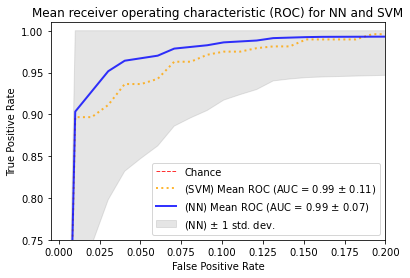

In [47]:
mean_fpr = np.linspace(0, 1, 100)

# Scores for neural net
tprs_nn = []
aucs_nn = []

# Scores for SVM Classifier
tprs_clf = []
aucs_clf = []

fig, ax = plt.subplots()

def train_models_for_dataset(target_data, other_data) -> TestResult:
    result = TestResult()
    # Format Dataset
    label = [1]*len(target_data) + [0]*len(other_data)
    data = target_data + other_data
    data = np.array(data)
    label = np.array(label)
    
    # Split train and test data
    X_train, X_test, y_train, y_test = train_test_split(
                                        data, label, test_size=0.35, stratify=label)

    # Train and evaluate deep neural network
    model = build_model()

    model.fit(
    X_train,
    y_train,
    epochs=200,
    verbose=0
    )

    # Predict test data with NN
    predictions = model.predict(X_test)
    y_pred_nn = [1 if y>NN_THRESHOLD else 0 for y in predictions]

    # Calculate accuracy for NN
    result.score_nn = sum(y_pred_nn == y_test)/len(y_pred_nn)

    # Calculate confusion matrix for NN
    mtx_nn = metrics.confusion_matrix(y_test, y_pred_nn)
    if len(mtx_nn) == 1:
        mtx_nn = np.array([y_test.count(0),0],[0, y_test.count(1)])
    result.mtx_nn = mtx_nn
    tn, fp, fn, tp = mtx_nn.ravel()
    result.sensitivity_nn = tp/(tp+fn)
    result.specificity_nn = tn/(tn+fp)

    # Calculate ROC for NN
    fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, predictions)
    auc_nn = roc_auc_score(y_test, y_pred_nn)

    interp_tpr_nn = np.interp(mean_fpr, fpr_nn, tpr_nn)
    interp_tpr_nn[0] = 0.0
    tprs_nn.append(interp_tpr_nn)
    #ax.plot(fpr_nn, tpr_nn, color='red', alpha=0.1)
    aucs_nn.append(auc_nn)

    
    # Train and evaluate SVM Classifier
    sgd_clf = SGDClassifier(random_state=42, max_iter=10000, tol=0.001, 
                            loss="hinge", class_weight={1:3, 0:1})
    sgd_clf.fit(X_train, y_train)
    y_pred_clf = sgd_clf.predict(X_test)
    result.score_clf = sgd_clf.score(X_test, y_test)
    
    # Calculate confusion matrix for SVM Classifier
    mtx = metrics.confusion_matrix(y_test, y_pred_clf)
    if len(mtx) == 1:
        mtx = np.array([y_test.count(0),0],[0, y_test.count(1)])
    tn, fp, fn, tp = mtx.ravel()
    result.mtx_clf = mtx

    result.sensitivity_clf = tp/(tp+fn)
    result.specificity_clf = tn/(tn+fp)

    sgd_prediction_scores = sgd_clf.decision_function(X_test)

    # Calculate ROC for SVM Classifier
    fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, sgd_prediction_scores)
    auc_clf = roc_auc_score(y_test, y_pred_clf)

    interp_tpr_clf = np.interp(mean_fpr, fpr_clf, tpr_clf)
    interp_tpr_clf[0] = 0.0
    tprs_clf.append(interp_tpr_clf)
    #ax.plot(fpr_clf, tpr_clf, color='blue', alpha=0.1)
    aucs_clf.append(auc_clf)
    
    return result

    
result_data = {'clf': [], 'nn': []}
mtx_clf = np.array([[0,  0],[ 0,  0]])
mtx_nn = np.array([[0,  0],[ 0,  0]])
for X in range(1, 25): ##############
    c = []
    n = []
    target_data, negative_sets = cross_test_subject(data, X, 5, 92)
    for set in negative_sets:
        tr = train_models_for_dataset(target_data, set)
        mtx_nn += tr.mtx_nn
        mtx_clf += tr.mtx_clf
        n.append(tr.score_nn)
        c.append(tr.score_clf)

    result_data['clf'].append(c)
    result_data['nn'].append(n)
    
print_scores(mtx_nn, "NN")
print_scores(mtx_clf, "SVM")


# ROC AUC Plot
ax.plot([0, 1], [0, 1], linestyle="--", lw=1, color="r", label="Chance", alpha=0.8)

mean_tpr_clf = np.mean(tprs_clf, axis=0)
mean_tpr_clf[-1] = 1.0
mean_auc_clf = auc(mean_fpr, mean_tpr_clf)
std_auc_clf = np.std(aucs_clf)
ax.plot(
    mean_fpr,
    mean_tpr_clf,
    color="orange",
    linestyle='dotted',
    label=r"(SVM) Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc_clf, std_auc_clf),
    lw=2,
    alpha=0.8,
)

mean_tpr_nn = np.mean(tprs_nn, axis=0)
mean_tpr_nn[-1] = 1.0
mean_auc_nn = auc(mean_fpr, mean_tpr_nn)
std_auc_nn = np.std(aucs_nn)
ax.plot(
    mean_fpr,
    mean_tpr_nn,
    color="b",
    label=r"(NN) Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc_nn, std_auc_nn),
    lw=2,
    alpha=0.8,
)



std_tpr_nn = np.std(tprs_nn, axis=0)
tprs_upper_nn = np.minimum(mean_tpr_nn + std_tpr_nn, 1)
tprs_lower_nn = np.maximum(mean_tpr_nn - std_tpr_nn, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower_nn,
    tprs_upper_nn,
    color="grey",
    alpha=0.2,
    label=r"(NN) $\pm$ 1 std. dev.",
)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Mean receiver operating characteristic (ROC) for NN and SVM",
)
ax.legend(loc="lower right")
plt.savefig("mean_roc_auc_nn_svm.png", dpi=900)
plt.ylim(0.75, 1.01)
plt.xlim(-0.005, 0.2)
plt.savefig("mean_roc_auc_nn_svm_80.png", dpi=900)
plt.show()


    

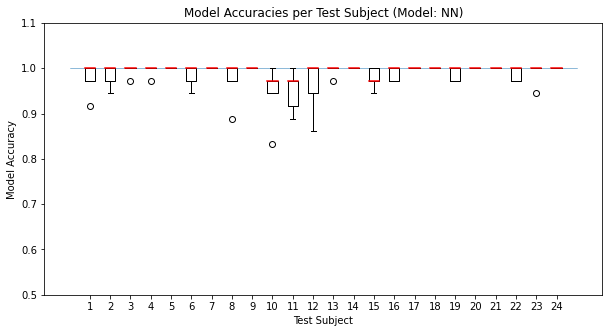

In [48]:
accuracy_box_plot(result_data.get("nn"), "NN")
    

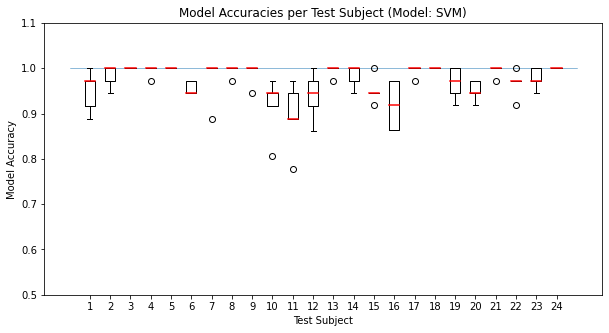

In [49]:
accuracy_box_plot(result_data.get("clf"), "SVM")

In [51]:
tn = 3858
fp = 37
fn = 19
tp = 471
mcc = (tp*tn - fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
mcc

0.9368791026413593